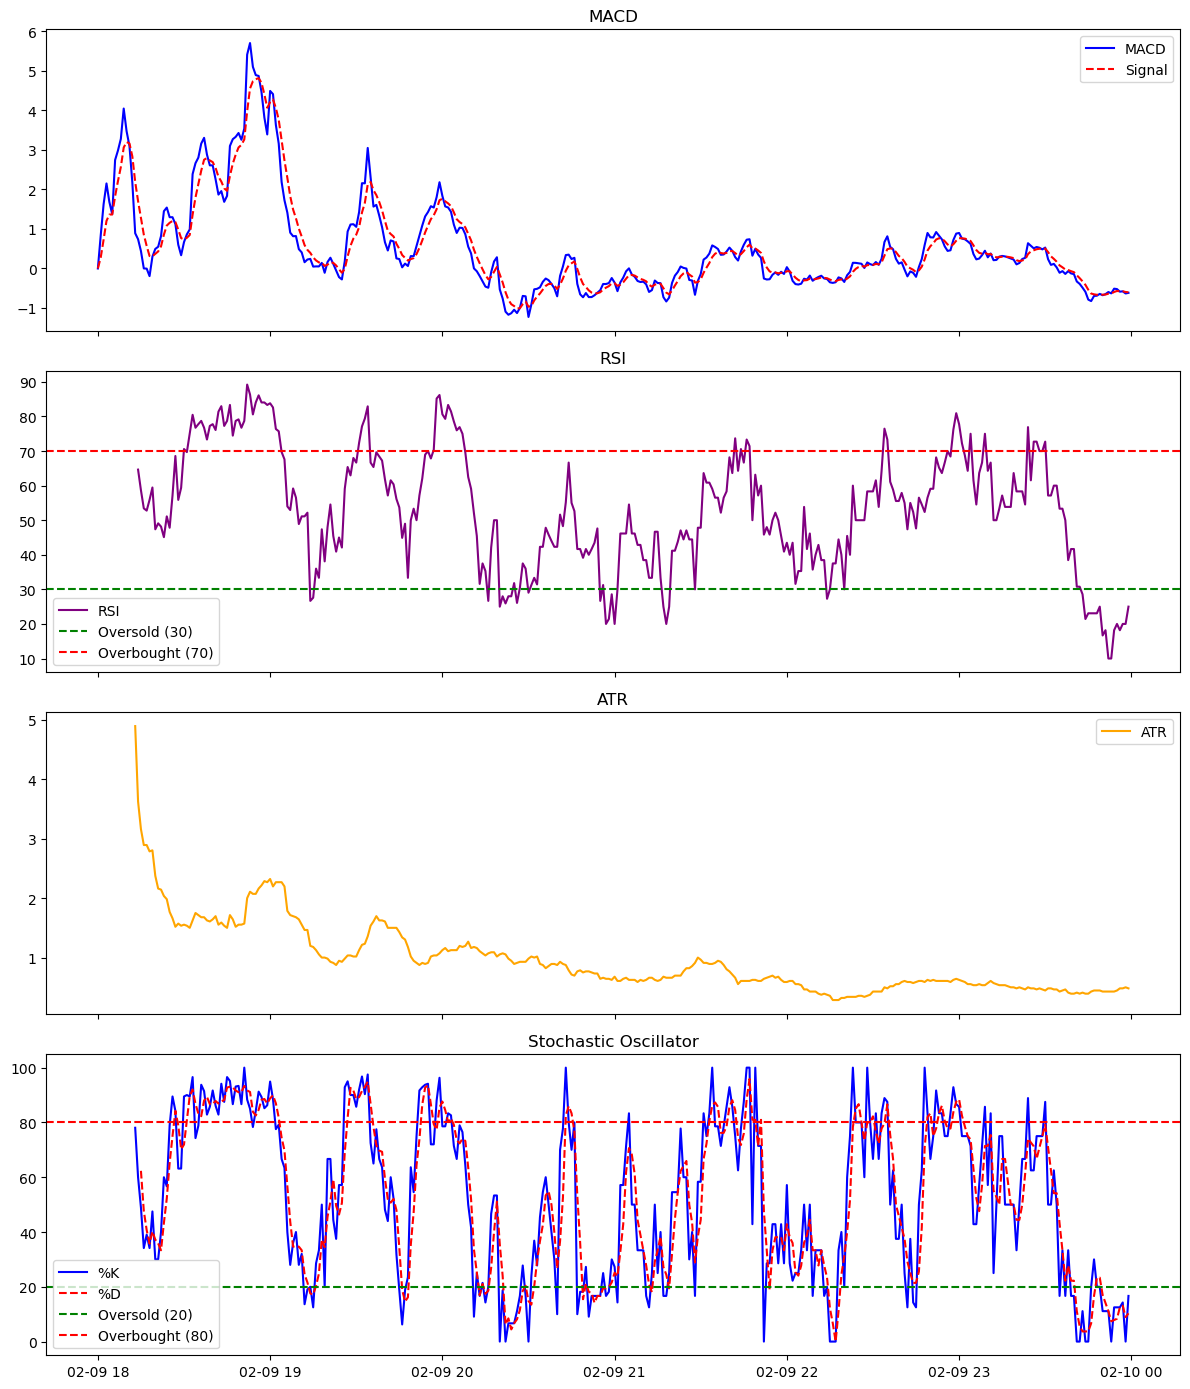

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# ===== Step 1: Load Data from CSV =====
file_path = "/Users/carl/Desktop/Speciale/Kode/Data/ES_1min_sample.csv"  
df = pd.read_csv(file_path)

# Ensure proper datetime formatting and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# ===== Step 2: Choose a Single Day =====
chosen_date = df.index[0].date()
df_day = df[df.index.date == chosen_date].copy()

# ===== Step 3: Compute ATR for Dynamic Stops =====
df_day['H-L'] = df_day['high'] - df_day['low']
df_day['H-PC'] = (df_day['high'] - df_day['close'].shift(1)).abs()
df_day['L-PC'] = (df_day['low'] - df_day['close'].shift(1)).abs()
df_day['TR'] = df_day[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_day['ATR'] = df_day['TR'].rolling(window=14).mean()

# ===== Step 4: Compute MACD =====
best_short_ema, best_long_ema, best_signal = 3, 15, 5  # Best found in optimization
df_day["MACD"] = df_day["close"].ewm(span=best_short_ema, adjust=False).mean() - \
                 df_day["close"].ewm(span=best_long_ema, adjust=False).mean()
df_day["Signal_MACD"] = df_day["MACD"].ewm(span=best_signal, adjust=False).mean()

# Generate MACD trade signal: 1 for buy, -1 for sell
df_day["Signal_MACD_Trade"] = 0
df_day.loc[df_day["MACD"] > df_day["Signal_MACD"], "Signal_MACD_Trade"] = 1
df_day.loc[df_day["MACD"] < df_day["Signal_MACD"], "Signal_MACD_Trade"] = -1

# ===== Step 5: Compute RSI =====
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_day['RSI'] = compute_RSI(df_day['close'])
# Generate basic RSI signals:
# Buy if RSI < 30, Sell if RSI > 70.
df_day["Signal_RSI_Trade"] = 0
df_day.loc[df_day["RSI"] < 30, "Signal_RSI_Trade"] = 1
df_day.loc[df_day["RSI"] > 70, "Signal_RSI_Trade"] = -1

# ===== Step 6: Compute Stochastic Oscillator =====
lookback = 14
df_day['Stoch_%K'] = ((df_day['close'] - df_day['low'].rolling(window=lookback).min()) /
                      (df_day['high'].rolling(window=lookback).max() - df_day['low'].rolling(window=lookback).min())) * 100
df_day['Stoch_%D'] = df_day['Stoch_%K'].rolling(window=3).mean()

# Generate Stochastic signals:
# Buy when %K crosses above %D in oversold region (<20); Sell when %K crosses below %D in overbought region (>80)
df_day["Signal_Stoch_Trade"] = 0
# For signal generation, we compare current %K and %D with previous values:
df_day["prev_%K"] = df_day['Stoch_%K'].shift(1)
df_day["prev_%D"] = df_day['Stoch_%D'].shift(1)

# Buy condition: cross up when previous %K < previous %D AND current %K > current %D and current %K < 20
buy_condition = (
    (df_day["prev_%K"] < df_day["prev_%D"]) &
    (df_day["Stoch_%K"] > df_day["Stoch_%D"]) &
    (df_day["Stoch_%K"] < 20)
)
# Sell condition: cross down when previous %K > previous %D AND current %K < current %D and current %K > 80
sell_condition = (
    (df_day["prev_%K"] > df_day["prev_%D"]) &
    (df_day["Stoch_%K"] < df_day["Stoch_%D"]) &
    (df_day["Stoch_%K"] > 80)
)
df_day.loc[buy_condition, "Signal_Stoch_Trade"] = 1
df_day.loc[sell_condition, "Signal_Stoch_Trade"] = -1

# ===== Step 7: Visualizing the Indicators =====
fig, axs = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

# MACD Visualization
axs[0].plot(df_day.index, df_day["MACD"], label="MACD", color="blue")
axs[0].plot(df_day.index, df_day["Signal_MACD"], label="Signal", color="red", linestyle="--")
axs[0].set_title("MACD")
axs[0].legend()

# RSI Visualization
axs[1].plot(df_day.index, df_day["RSI"], label="RSI", color="purple")
axs[1].axhline(30, color="green", linestyle="--", label="Oversold (30)")
axs[1].axhline(70, color="red", linestyle="--", label="Overbought (70)")
axs[1].set_title("RSI")
axs[1].legend()

# ATR Visualization (Volatility Measure)
axs[2].plot(df_day.index, df_day["ATR"], label="ATR", color="orange")
axs[2].set_title("ATR")
axs[2].legend()

# Stochastic Visualization
axs[3].plot(df_day.index, df_day["Stoch_%K"], label="%K", color="blue")
axs[3].plot(df_day.index, df_day["Stoch_%D"], label="%D", color="red", linestyle="--")
axs[3].axhline(20, color="green", linestyle="--", label="Oversold (20)")
axs[3].axhline(80, color="red", linestyle="--", label="Overbought (80)")
axs[3].set_title("Stochastic Oscillator")
axs[3].legend()

plt.tight_layout()
plt.show()


In [3]:
# Example Combined Signal: Use MACD and RSI together.
# Buy if both MACD and RSI give a buy signal; Sell if both give a sell signal.
df_day["Signal_Combined_MA_RSI"] = 0
combined_buy = (df_day["Signal_MACD_Trade"] == 1) & (df_day["Signal_RSI_Trade"] == 1)
combined_sell = (df_day["Signal_MACD_Trade"] == -1) & (df_day["Signal_RSI_Trade"] == -1)
df_day.loc[combined_buy, "Signal_Combined_MA_RSI"] = 1
df_day.loc[combined_sell, "Signal_Combined_MA_RSI"] = -1

# Similarly, you can combine any two (or three) signals:
# For instance, MACD + Stochastic, RSI + Stochastic, or even MACD + RSI + Stochastic.


Strategy: MACD
Final Portfolio Value: $1,000,448.75
Total Profit: $441.75
Total Trades Executed: 33
Trade Log:
SHORT SELL: 33 @ 6038.00
STOP LOSS SHORT: 33 @ 6045.75 | Loss: -256.75
BUY: 33 @ 6045.75
TAKE PROFIT LONG: 33 @ 6052.00 | Profit: 205.25
BUY: 33 @ 6052.00
TAKE PROFIT LONG: 33 @ 6059.50 | Profit: 246.50
BUY: 33 @ 6059.50
TAKE PROFIT LONG: 33 @ 6067.00 | Profit: 246.50
BUY: 32 @ 6067.00
STOP LOSS LONG: 32 @ 6064.50 | Loss: -81.00
BUY: 32 @ 6064.50
TAKE PROFIT LONG: 32 @ 6069.25 | Profit: 151.00
BUY: 32 @ 6069.25
STOP LOSS LONG: 32 @ 6067.50 | Loss: -57.00
SHORT SELL: 32 @ 6067.50
TAKE PROFIT SHORT: 32 @ 6063.75 | Profit: 119.00
SHORT SELL: 33 @ 6063.75
STOP LOSS SHORT: 33 @ 6065.50 | Loss: -58.75
BUY: 32 @ 6065.50
STOP LOSS LONG: 32 @ 6064.00 | Loss: -49.00
SHORT SELL: 32 @ 6064.00
STOP LOSS SHORT: 32 @ 6065.50 | Loss: -49.00
BUY: 32 @ 6065.50
STOP LOSS LONG: 32 @ 6064.00 | Loss: -49.00
SHORT SELL: 32 @ 6064.00
TAKE PROFIT SHORT: 32 @ 6061.25 | Profit: 87.00
SHORT SELL: 33 @ 60

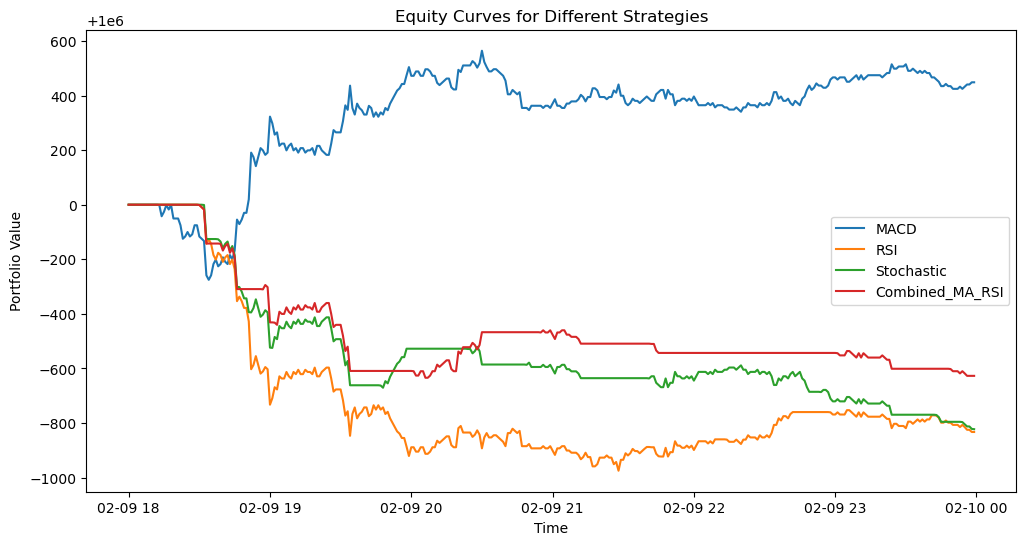

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# (Assuming the earlier steps have been executed and df_day has been computed
# with columns: 'close', 'ATR', 'Signal_MACD_Trade', 'Signal_RSI_Trade', 
# 'Signal_Stoch_Trade', and 'Signal_Combined_MA_RSI'.)
# ================================

# ----- Trade Sizing Function -----
def calculate_trade_size(price, cash_available):
    max_trade_size = 500
    return min(max_trade_size, int((cash_available * 0.2) / price))

# ----- Backtesting Function -----
def backtest_strategy(df, signal_col, initial_cash=1000000,
                      transaction_cost=1.00, stop_loss_multiplier=1.5,
                      take_profit_multiplier=3.0):
    cash = initial_cash
    position = 0
    entry_price = None
    # Initialize stop-loss and take-profit levels
    stop_loss_price = None
    take_profit_price = None
    
    total_profit = 0
    trade_log = []
    portfolio_value = []
    
    for i in range(len(df)):
        price = df["close"].iloc[i]
        signal_val = df[signal_col].iloc[i]
        current_atr = df["ATR"].iloc[i]

        # Skip the iteration if ATR is not available
        if np.isnan(current_atr):
            portfolio_value.append(cash if position == 0 else (cash + position * price))
            continue

        # ===== Check for Stop-Loss/Take-Profit Conditions =====
        # Long positions
        if position > 0:
            if price >= take_profit_price:
                trade_profit = (price - entry_price) * position - transaction_cost
                cash += position * price - transaction_cost
                total_profit += trade_profit
                trade_log.append(f"TAKE PROFIT LONG: {position} @ {price:.2f} | Profit: {trade_profit:.2f}")
                position = 0
                entry_price = None
            elif price <= stop_loss_price:
                trade_profit = (price - entry_price) * position - transaction_cost
                cash += position * price - transaction_cost
                total_profit += trade_profit
                trade_log.append(f"STOP LOSS LONG: {position} @ {price:.2f} | Loss: {trade_profit:.2f}")
                position = 0
                entry_price = None

        # Short positions
        elif position < 0:
            if price <= take_profit_price:
                trade_profit = (entry_price - price) * abs(position) - transaction_cost
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                trade_log.append(f"TAKE PROFIT SHORT: {abs(position)} @ {price:.2f} | Profit: {trade_profit:.2f}")
                position = 0
                entry_price = None
            elif price >= stop_loss_price:
                trade_profit = (entry_price - price) * abs(position) - transaction_cost
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                trade_log.append(f"STOP LOSS SHORT: {abs(position)} @ {price:.2f} | Loss: {trade_profit:.2f}")
                position = 0
                entry_price = None

        # ===== Entry Conditions =====
        # Only enter a new trade if no current position exists.
        if position == 0:
            if signal_val == 1:  # Buy signal
                shares = calculate_trade_size(price, cash)
                if shares > 0:
                    cash -= shares * price + transaction_cost
                    entry_price = price
                    position = shares
                    stop_loss_price = entry_price - stop_loss_multiplier * current_atr
                    take_profit_price = entry_price + take_profit_multiplier * current_atr
                    trade_log.append(f"BUY: {shares} @ {price:.2f}")
            elif signal_val == -1:  # Short sell signal
                shares = calculate_trade_size(price, cash)
                if shares > 0:
                    cash += shares * price - transaction_cost
                    entry_price = price
                    position = -shares
                    stop_loss_price = entry_price + stop_loss_multiplier * current_atr
                    take_profit_price = entry_price - take_profit_multiplier * current_atr
                    trade_log.append(f"SHORT SELL: {shares} @ {price:.2f}")

        # Record portfolio value
        portfolio_value.append(cash if position == 0 else (cash + position * price))

    return {
        'portfolio_value': portfolio_value,
        'final_cash': cash,
        'total_profit': total_profit,
        'trade_log': trade_log,
        'final_value': portfolio_value[-1]
    }

# ----- Define Strategy Signal Columns -----
# (These columns should exist in df_day from your earlier calculations.)
strategies = {
    'MACD': 'Signal_MACD_Trade',
    'RSI': 'Signal_RSI_Trade',
    'Stochastic': 'Signal_Stoch_Trade',
    'Combined_MA_RSI': 'Signal_Combined_MA_RSI'
}

# ----- Run Backtests for All Strategies -----
results = {}

for strat_name, signal_col in strategies.items():
    results[strat_name] = backtest_strategy(df_day, signal_col)
    print("=" * 50)
    print(f"Strategy: {strat_name}")
    print(f"Final Portfolio Value: ${results[strat_name]['final_value']:,.2f}")
    print(f"Total Profit: ${results[strat_name]['total_profit']:,.2f}")
    print(f"Total Trades Executed: {len(results[strat_name]['trade_log'])}")
    print("=" * 50)
    print("Trade Log:")
    for log in results[strat_name]['trade_log']:
        print(log)
    print("\n")

# ----- Create a Summary DataFrame -----
summary_data = []
for strat_name, res in results.items():
    summary_data.append({
        'Strategy': strat_name,
        'Final Value': res['final_value'],
        'Total Profit': res['total_profit'],
        'Total Trades': len(res['trade_log'])
    })

summary_df = pd.DataFrame(summary_data)
print("Summary of Backtest Results:")
print(summary_df)

# ----- Visualize Portfolio Equity Curves for Each Strategy -----
plt.figure(figsize=(12, 6))
for strat_name, res in results.items():
    plt.plot(df_day.index, res['portfolio_value'], label=strat_name)
plt.title("Equity Curves for Different Strategies")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


Strategy: MACD
Final Portfolio Value: $1,000,448.75
Total Profit: $441.75
Sharpe Ratio (per period): 0.0535
Maximum Drawdown: -0.0275%
Total Trades Executed: 33
Trade Log:
   SHORT SELL: 33 @ 6038.00
   STOP LOSS SHORT: 33 @ 6045.75 | Loss: -256.75
   BUY: 33 @ 6045.75
   TAKE PROFIT LONG: 33 @ 6052.00 | Profit: 205.25
   BUY: 33 @ 6052.00
   TAKE PROFIT LONG: 33 @ 6059.50 | Profit: 246.50
   BUY: 33 @ 6059.50
   TAKE PROFIT LONG: 33 @ 6067.00 | Profit: 246.50
   BUY: 32 @ 6067.00
   STOP LOSS LONG: 32 @ 6064.50 | Loss: -81.00
   BUY: 32 @ 6064.50
   TAKE PROFIT LONG: 32 @ 6069.25 | Profit: 151.00
   BUY: 32 @ 6069.25
   STOP LOSS LONG: 32 @ 6067.50 | Loss: -57.00
   SHORT SELL: 32 @ 6067.50
   TAKE PROFIT SHORT: 32 @ 6063.75 | Profit: 119.00
   SHORT SELL: 33 @ 6063.75
   STOP LOSS SHORT: 33 @ 6065.50 | Loss: -58.75
   BUY: 32 @ 6065.50
   STOP LOSS LONG: 32 @ 6064.00 | Loss: -49.00
   SHORT SELL: 32 @ 6064.00
   STOP LOSS SHORT: 32 @ 6065.50 | Loss: -49.00
   BUY: 32 @ 6065.50
   STO

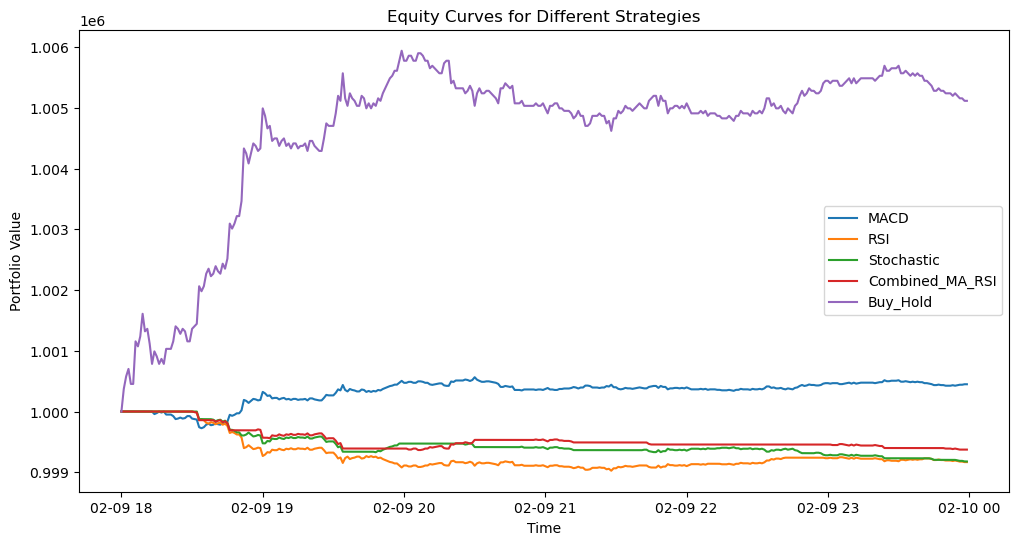

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# 1. Data Loading and Indicator Calculations
# (Assuming you have already loaded and processed the data)
# ================================

file_path = "/Users/carl/Desktop/Speciale/Kode/Data/ES_1min_sample.csv"  
df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Choose a single day for analysis
chosen_date = df.index[0].date()
df_day = df[df.index.date == chosen_date].copy()

# Compute ATR for dynamic stops
df_day['H-L'] = df_day['high'] - df_day['low']
df_day['H-PC'] = (df_day['high'] - df_day['close'].shift(1)).abs()
df_day['L-PC'] = (df_day['low'] - df_day['close'].shift(1)).abs()
df_day['TR'] = df_day[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_day['ATR'] = df_day['TR'].rolling(window=14).mean()

# --- MACD ---
best_short_ema, best_long_ema, best_signal = 3, 15, 5
df_day["MACD"] = df_day["close"].ewm(span=best_short_ema, adjust=False).mean() - \
                 df_day["close"].ewm(span=best_long_ema, adjust=False).mean()
df_day["Signal_MACD"] = df_day["MACD"].ewm(span=best_signal, adjust=False).mean()
df_day["Signal_MACD_Trade"] = 0
df_day.loc[df_day["MACD"] > df_day["Signal_MACD"], "Signal_MACD_Trade"] = 1
df_day.loc[df_day["MACD"] < df_day["Signal_MACD"], "Signal_MACD_Trade"] = -1

# --- RSI ---
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_day['RSI'] = compute_RSI(df_day['close'])
df_day["Signal_RSI_Trade"] = 0
df_day.loc[df_day["RSI"] < 30, "Signal_RSI_Trade"] = 1
df_day.loc[df_day["RSI"] > 70, "Signal_RSI_Trade"] = -1

# --- Stochastic Oscillator ---
lookback = 14
df_day['Stoch_%K'] = ((df_day['close'] - df_day['low'].rolling(window=lookback).min()) /
                      (df_day['high'].rolling(window=lookback).max() - df_day['low'].rolling(window=lookback).min())) * 100
df_day['Stoch_%D'] = df_day['Stoch_%K'].rolling(window=3).mean()
df_day["Signal_Stoch_Trade"] = 0
df_day["prev_%K"] = df_day['Stoch_%K'].shift(1)
df_day["prev_%D"] = df_day['Stoch_%D'].shift(1)
buy_condition = (
    (df_day["prev_%K"] < df_day["prev_%D"]) &
    (df_day["Stoch_%K"] > df_day["Stoch_%D"]) &
    (df_day["Stoch_%K"] < 20)
)
sell_condition = (
    (df_day["prev_%K"] > df_day["prev_%D"]) &
    (df_day["Stoch_%K"] < df_day["Stoch_%D"]) &
    (df_day["Stoch_%K"] > 80)
)
df_day.loc[buy_condition, "Signal_Stoch_Trade"] = 1
df_day.loc[sell_condition, "Signal_Stoch_Trade"] = -1

# --- Combined Strategy (Example: MACD + RSI) ---
df_day["Signal_Combined_MA_RSI"] = 0
combined_buy = (df_day["Signal_MACD_Trade"] == 1) & (df_day["Signal_RSI_Trade"] == 1)
combined_sell = (df_day["Signal_MACD_Trade"] == -1) & (df_day["Signal_RSI_Trade"] == -1)
df_day.loc[combined_buy, "Signal_Combined_MA_RSI"] = 1
df_day.loc[combined_sell, "Signal_Combined_MA_RSI"] = -1

# ================================
# 2. Helper Functions for Trading & Performance Metrics
# ================================

# Trade sizing function remains the same.
def calculate_trade_size(price, cash_available):
    max_trade_size = 500
    return min(max_trade_size, int((cash_available * 0.2) / price))

# Backtesting function for oscillator-based strategies.
def backtest_strategy(df, signal_col, initial_cash=1000000,
                      transaction_cost=1.00, stop_loss_multiplier=1.5,
                      take_profit_multiplier=3.0):
    cash = initial_cash
    position = 0
    entry_price = None
    stop_loss_price = None
    take_profit_price = None
    total_profit = 0
    trade_log = []
    portfolio_value = []
    
    for i in range(len(df)):
        price = df["close"].iloc[i]
        signal_val = df[signal_col].iloc[i]
        current_atr = df["ATR"].iloc[i]
    
        # Skip iteration if ATR is not available.
        if np.isnan(current_atr):
            portfolio_value.append(cash if position == 0 else (cash + position * price))
            continue
    
        # --- Check Stop-Loss / Take-Profit Conditions ---
        if position > 0:  # Long position
            if price >= take_profit_price:
                trade_profit = (price - entry_price) * position - transaction_cost
                cash += position * price - transaction_cost
                total_profit += trade_profit
                trade_log.append(f"TAKE PROFIT LONG: {position} @ {price:.2f} | Profit: {trade_profit:.2f}")
                position = 0
                entry_price = None
            elif price <= stop_loss_price:
                trade_profit = (price - entry_price) * position - transaction_cost
                cash += position * price - transaction_cost
                total_profit += trade_profit
                trade_log.append(f"STOP LOSS LONG: {position} @ {price:.2f} | Loss: {trade_profit:.2f}")
                position = 0
                entry_price = None
    
        elif position < 0:  # Short position
            if price <= take_profit_price:
                trade_profit = (entry_price - price) * abs(position) - transaction_cost
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                trade_log.append(f"TAKE PROFIT SHORT: {abs(position)} @ {price:.2f} | Profit: {trade_profit:.2f}")
                position = 0
                entry_price = None
            elif price >= stop_loss_price:
                trade_profit = (entry_price - price) * abs(position) - transaction_cost
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                trade_log.append(f"STOP LOSS SHORT: {abs(position)} @ {price:.2f} | Loss: {trade_profit:.2f}")
                position = 0
                entry_price = None
    
        # --- Entry Conditions ---
        if position == 0:
            if signal_val == 1:  # Buy signal
                shares = calculate_trade_size(price, cash)
                if shares > 0:
                    cash -= shares * price + transaction_cost
                    entry_price = price
                    position = shares
                    stop_loss_price = entry_price - stop_loss_multiplier * current_atr
                    take_profit_price = entry_price + take_profit_multiplier * current_atr
                    trade_log.append(f"BUY: {shares} @ {price:.2f}")
            elif signal_val == -1:  # Short signal
                shares = calculate_trade_size(price, cash)
                if shares > 0:
                    cash += shares * price - transaction_cost
                    entry_price = price
                    position = -shares
                    stop_loss_price = entry_price + stop_loss_multiplier * current_atr
                    take_profit_price = entry_price - take_profit_multiplier * current_atr
                    trade_log.append(f"SHORT SELL: {shares} @ {price:.2f}")
    
        portfolio_value.append(cash if position == 0 else (cash + position * price))
    
    return {
        'portfolio_value': portfolio_value,
        'final_cash': cash,
        'total_profit': total_profit,
        'trade_log': trade_log,
        'final_value': portfolio_value[-1]
    }

# Backtesting function for Buy and Hold strategy.
def backtest_buy_hold(df, initial_cash=1000000):
    price0 = df["close"].iloc[0]
    shares = int(initial_cash / price0)
    cash_remaining = initial_cash - shares * price0
    portfolio_value = []
    for price in df["close"]:
        portfolio_value.append(cash_remaining + shares * price)
    total_profit = portfolio_value[-1] - initial_cash
    return {
        'portfolio_value': portfolio_value,
        'final_value': portfolio_value[-1],
        'total_profit': total_profit,
        'trade_log': [f"BUY AND HOLD: Bought {shares} shares at {price0:.2f}"]
    }

# Performance Metrics: Maximum Drawdown and Sharpe Ratio (simple version).
def max_drawdown(portfolio_values):
    portfolio_arr = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_arr)
    drawdowns = (portfolio_arr - running_max) / running_max
    return drawdowns.min()  # returns a negative value

def sharpe_ratio(portfolio_values):
    returns = pd.Series(portfolio_values).pct_change().dropna()
    mean_ret = returns.mean()
    std_ret = returns.std()
    if std_ret == 0:
        return np.nan
    return mean_ret / std_ret

# ================================
# 3. Run Backtests for All Strategies
# ================================

# Define the strategies and assign signal columns; include Buy & Hold.
strategies = {
    'MACD': 'Signal_MACD_Trade',
    'RSI': 'Signal_RSI_Trade',
    'Stochastic': 'Signal_Stoch_Trade',
    'Combined_MA_RSI': 'Signal_Combined_MA_RSI',
    'Buy_Hold': None  # Special key; will use the buy & hold function.
}

results = {}

for strat_name, signal_col in strategies.items():
    if strat_name == 'Buy_Hold':
        res = backtest_buy_hold(df_day)
    else:
        res = backtest_strategy(df_day, signal_col)
    # Compute additional metrics:
    res['sharpe_ratio'] = sharpe_ratio(res['portfolio_value'])
    res['max_drawdown'] = max_drawdown(res['portfolio_value'])
    results[strat_name] = res

    print("=" * 50)
    print(f"Strategy: {strat_name}")
    print(f"Final Portfolio Value: ${res['final_value']:,.2f}")
    print(f"Total Profit: ${res['total_profit']:,.2f}")
    print(f"Sharpe Ratio (per period): {res['sharpe_ratio']:.4f}")
    print(f"Maximum Drawdown: {res['max_drawdown']:.4%}")
    print(f"Total Trades Executed: {len(res['trade_log'])}")
    print("Trade Log:")
    for log in res['trade_log']:
        print("  ", log)
    print("\n")

# ------------------------
# Summary DataFrame
# ------------------------
summary_data = []
for strat_name, res in results.items():
    summary_data.append({
        'Strategy': strat_name,
        'Final Value': res['final_value'],
        'Total Profit': res['total_profit'],
        'Sharpe Ratio': res['sharpe_ratio'],
        'Max Drawdown': res['max_drawdown'],
        'Total Trades': len(res['trade_log'])
    })

summary_df = pd.DataFrame(summary_data)
print("Summary of Backtest Results:")
print(summary_df)

# ------------------------
# Visualize Equity Curves for Each Strategy
# ------------------------
plt.figure(figsize=(12, 6))
for strat_name, res in results.items():
    plt.plot(df_day.index, res['portfolio_value'], label=strat_name)
plt.title("Equity Curves for Different Strategies")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


Strategy: MACD
Final Portfolio Value: $994,758.75
Total Profit: $-4,404.75
Sharpe Ratio (per period): -0.0105
Maximum Drawdown: -0.68%
Total Trades Executed: 1771
Trade Log:
   SHORT SELL: 33 @ 6038.00
   STOP LOSS SHORT: 33 @ 6045.75 | Loss: -256.75
   BUY: 33 @ 6045.75
   TAKE PROFIT LONG: 33 @ 6052.00 | Profit: 205.25
   BUY: 33 @ 6052.00
   TAKE PROFIT LONG: 33 @ 6059.50 | Profit: 246.50
   BUY: 33 @ 6059.50
   TAKE PROFIT LONG: 33 @ 6067.00 | Profit: 246.50
   BUY: 32 @ 6067.00
   STOP LOSS LONG: 32 @ 6064.50 | Loss: -81.00
   BUY: 32 @ 6064.50
   TAKE PROFIT LONG: 32 @ 6069.25 | Profit: 151.00
   BUY: 32 @ 6069.25
   STOP LOSS LONG: 32 @ 6067.50 | Loss: -57.00
   SHORT SELL: 32 @ 6067.50
   TAKE PROFIT SHORT: 32 @ 6063.75 | Profit: 119.00
   SHORT SELL: 33 @ 6063.75
   STOP LOSS SHORT: 33 @ 6065.50 | Loss: -58.75
   BUY: 32 @ 6065.50
   STOP LOSS LONG: 32 @ 6064.00 | Loss: -49.00
   SHORT SELL: 32 @ 6064.00
   STOP LOSS SHORT: 32 @ 6065.50 | Loss: -49.00
   BUY: 32 @ 6065.50
   S

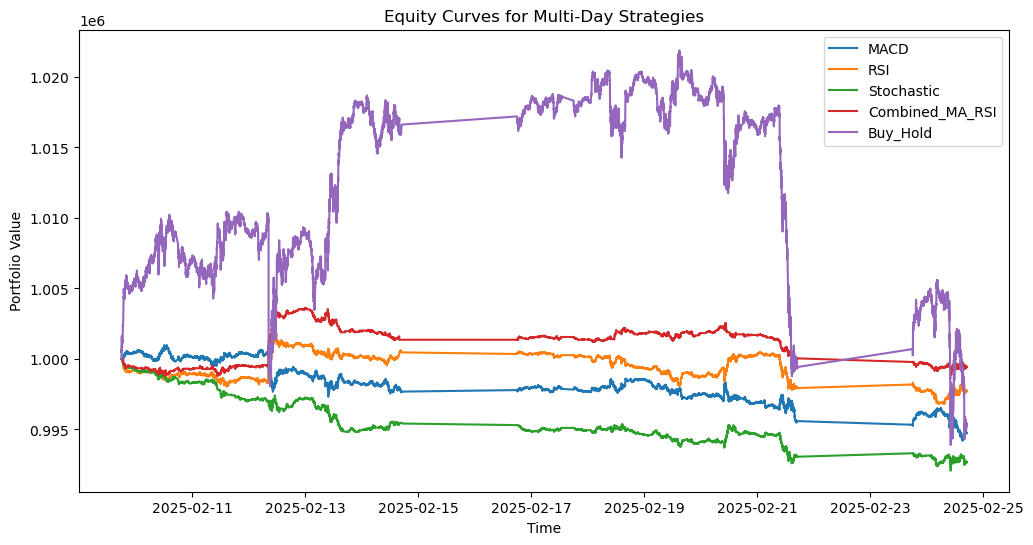

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# 1. Data Loading and Indicator Calculations (Multi-Day)
# ================================
file_path = "/Users/carl/Desktop/Speciale/Kode/Data/ES_1min_sample.csv"  
df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Instead of selecting one day, we run on the entire dataset.
df_sim = df.copy()

# --- ATR Calculation ---
df_sim['H-L'] = df_sim['high'] - df_sim['low']
df_sim['H-PC'] = (df_sim['high'] - df_sim['close'].shift(1)).abs()
df_sim['L-PC'] = (df_sim['low'] - df_sim['close'].shift(1)).abs()
df_sim['TR'] = df_sim[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_sim['ATR'] = df_sim['TR'].rolling(window=14).mean()

# --- MACD Calculation ---
best_short_ema, best_long_ema, best_signal = 3, 15, 5
df_sim["MACD"] = df_sim["close"].ewm(span=best_short_ema, adjust=False).mean() - \
                 df_sim["close"].ewm(span=best_long_ema, adjust=False).mean()
df_sim["Signal_MACD"] = df_sim["MACD"].ewm(span=best_signal, adjust=False).mean()
df_sim["Signal_MACD_Trade"] = 0
df_sim.loc[df_sim["MACD"] > df_sim["Signal_MACD"], "Signal_MACD_Trade"] = 1
df_sim.loc[df_sim["MACD"] < df_sim["Signal_MACD"], "Signal_MACD_Trade"] = -1

# --- RSI Calculation ---
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_sim['RSI'] = compute_RSI(df_sim['close'])
df_sim["Signal_RSI_Trade"] = 0
df_sim.loc[df_sim["RSI"] < 30, "Signal_RSI_Trade"] = 1
df_sim.loc[df_sim["RSI"] > 70, "Signal_RSI_Trade"] = -1

# --- Stochastic Oscillator Calculation ---
lookback = 14
df_sim['Stoch_%K'] = ((df_sim['close'] - df_sim['low'].rolling(window=lookback).min()) /
                      (df_sim['high'].rolling(window=lookback).max() - df_sim['low'].rolling(window=lookback).min())) * 100
df_sim['Stoch_%D'] = df_sim['Stoch_%K'].rolling(window=3).mean()
df_sim["Signal_Stoch_Trade"] = 0
df_sim["prev_%K"] = df_sim['Stoch_%K'].shift(1)
df_sim["prev_%D"] = df_sim['Stoch_%D'].shift(1)
buy_condition = (
    (df_sim["prev_%K"] < df_sim["prev_%D"]) &
    (df_sim["Stoch_%K"] > df_sim["Stoch_%D"]) &
    (df_sim["Stoch_%K"] < 20)
)
sell_condition = (
    (df_sim["prev_%K"] > df_sim["prev_%D"]) &
    (df_sim["Stoch_%K"] < df_sim["Stoch_%D"]) &
    (df_sim["Stoch_%K"] > 80)
)
df_sim.loc[buy_condition, "Signal_Stoch_Trade"] = 1
df_sim.loc[sell_condition, "Signal_Stoch_Trade"] = -1

# --- Combined Strategy (Example: MACD + RSI) ---
df_sim["Signal_Combined_MA_RSI"] = 0
combined_buy = (df_sim["Signal_MACD_Trade"] == 1) & (df_sim["Signal_RSI_Trade"] == 1)
combined_sell = (df_sim["Signal_MACD_Trade"] == -1) & (df_sim["Signal_RSI_Trade"] == -1)
df_sim.loc[combined_buy, "Signal_Combined_MA_RSI"] = 1
df_sim.loc[combined_sell, "Signal_Combined_MA_RSI"] = -1

# ================================
# 2. Helper Functions for Trading & Performance Metrics
# ================================

def calculate_trade_size(price, cash_available):
    max_trade_size = 500
    return min(max_trade_size, int((cash_available * 0.2) / price))

def backtest_strategy(df, signal_col, initial_cash=1000000,
                      transaction_cost=1.00, stop_loss_multiplier=1.5,
                      take_profit_multiplier=3.0):
    cash = initial_cash
    position = 0
    entry_price = None
    stop_loss_price = None
    take_profit_price = None
    total_profit = 0
    trade_log = []
    portfolio_value = []
    
    # Loop over the entire multi-day dataset.
    for i in range(len(df)):
        price = df["close"].iloc[i]
        signal_val = df[signal_col].iloc[i]
        current_atr = df["ATR"].iloc[i]
    
        # If ATR is not computed yet, skip this data point.
        if np.isnan(current_atr):
            portfolio_value.append(cash if position == 0 else (cash + position * price))
            continue
    
        # --- Check Stop-Loss / Take-Profit Conditions ---
        if position > 0:  # Long position
            if price >= take_profit_price:
                trade_profit = (price - entry_price) * position - transaction_cost
                cash += position * price - transaction_cost
                total_profit += trade_profit
                trade_log.append(f"TAKE PROFIT LONG: {position} @ {price:.2f} | Profit: {trade_profit:.2f}")
                position = 0
                entry_price = None
            elif price <= stop_loss_price:
                trade_profit = (price - entry_price) * position - transaction_cost
                cash += position * price - transaction_cost
                total_profit += trade_profit
                trade_log.append(f"STOP LOSS LONG: {position} @ {price:.2f} | Loss: {trade_profit:.2f}")
                position = 0
                entry_price = None
    
        elif position < 0:  # Short position
            if price <= take_profit_price:
                trade_profit = (entry_price - price) * abs(position) - transaction_cost
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                trade_log.append(f"TAKE PROFIT SHORT: {abs(position)} @ {price:.2f} | Profit: {trade_profit:.2f}")
                position = 0
                entry_price = None
            elif price >= stop_loss_price:
                trade_profit = (entry_price - price) * abs(position) - transaction_cost
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                trade_log.append(f"STOP LOSS SHORT: {abs(position)} @ {price:.2f} | Loss: {trade_profit:.2f}")
                position = 0
                entry_price = None
    
        # --- Entry Conditions ---
        if position == 0:
            if signal_val == 1:  # Buy signal
                shares = calculate_trade_size(price, cash)
                if shares > 0:
                    cash -= shares * price + transaction_cost
                    entry_price = price
                    position = shares
                    stop_loss_price = entry_price - stop_loss_multiplier * current_atr
                    take_profit_price = entry_price + take_profit_multiplier * current_atr
                    trade_log.append(f"BUY: {shares} @ {price:.2f}")
            elif signal_val == -1:  # Short signal
                shares = calculate_trade_size(price, cash)
                if shares > 0:
                    cash += shares * price - transaction_cost
                    entry_price = price
                    position = -shares
                    stop_loss_price = entry_price + stop_loss_multiplier * current_atr
                    take_profit_price = entry_price - take_profit_multiplier * current_atr
                    trade_log.append(f"SHORT SELL: {shares} @ {price:.2f}")
    
        portfolio_value.append(cash if position == 0 else (cash + position * price))
    
    return {
        'portfolio_value': portfolio_value,
        'final_cash': cash,
        'total_profit': total_profit,
        'trade_log': trade_log,
        'final_value': portfolio_value[-1]
    }

def backtest_buy_hold(df, initial_cash=1000000):
    price0 = df["close"].iloc[0]
    shares = int(initial_cash / price0)
    cash_remaining = initial_cash - shares * price0
    portfolio_value = []
    for price in df["close"]:
        portfolio_value.append(cash_remaining + shares * price)
    total_profit = portfolio_value[-1] - initial_cash
    return {
        'portfolio_value': portfolio_value,
        'final_value': portfolio_value[-1],
        'total_profit': total_profit,
        'trade_log': [f"BUY AND HOLD: Bought {shares} shares at {price0:.2f}"]
    }

def max_drawdown(portfolio_values):
    portfolio_arr = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_arr)
    drawdowns = (portfolio_arr - running_max) / running_max
    return drawdowns.min()  # negative value

def sharpe_ratio(portfolio_values):
    returns = pd.Series(portfolio_values).pct_change().dropna()
    if returns.std() == 0:
        return np.nan
    return returns.mean() / returns.std()

# ================================
# 3. Run Backtests for All Strategies (Multi-Day)
# ================================
strategies = {
    'MACD': 'Signal_MACD_Trade',
    'RSI': 'Signal_RSI_Trade',
    'Stochastic': 'Signal_Stoch_Trade',
    'Combined_MA_RSI': 'Signal_Combined_MA_RSI',
    'Buy_Hold': None  # special case for Buy & Hold
}

results = {}

for strat_name, signal_col in strategies.items():
    if strat_name == 'Buy_Hold':
        res = backtest_buy_hold(df_sim)
    else:
        res = backtest_strategy(df_sim, signal_col)
    # Calculate additional performance metrics.
    res['sharpe_ratio'] = sharpe_ratio(res['portfolio_value'])
    res['max_drawdown'] = max_drawdown(res['portfolio_value'])
    results[strat_name] = res

    print("=" * 50)
    print(f"Strategy: {strat_name}")
    print(f"Final Portfolio Value: ${res['final_value']:,.2f}")
    print(f"Total Profit: ${res['total_profit']:,.2f}")
    print(f"Sharpe Ratio (per period): {res['sharpe_ratio']:.4f}")
    print(f"Maximum Drawdown: {res['max_drawdown']:.2%}")
    print(f"Total Trades Executed: {len(res['trade_log'])}")
    print("Trade Log:")
    for log in res['trade_log']:
        print("  ", log)
    print("\n")

# ------------------------
# Summary DataFrame
# ------------------------
summary_data = []
for strat_name, res in results.items():
    summary_data.append({
        'Strategy': strat_name,
        'Final Value': res['final_value'],
        'Total Profit': res['total_profit'],
        'Sharpe Ratio': res['sharpe_ratio'],
        'Max Drawdown': res['max_drawdown'],
        'Total Trades': len(res['trade_log'])
    })

summary_df = pd.DataFrame(summary_data)
print("Summary of Backtest Results:")
print(summary_df)

# ------------------------
# Visualize Equity Curves for Each Strategy
# ------------------------
plt.figure(figsize=(12, 6))
for strat_name, res in results.items():
    plt.plot(df_sim.index, res['portfolio_value'], label=strat_name)
plt.title("Equity Curves for Multi-Day Strategies")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()



===== PERFORMANCE COMPARISON =====
                             Final    Profit  Sharpe  MaxDD  Trades
File        Strategy                                               
03feb-18feb Buy&Hold    1031855.25  31855.25    0.01  -0.02       1
            Combined     998821.75  -1178.25   -0.00  -0.00     393
            MACD         990118.75  -9881.25   -0.01  -0.01     952
            RSI          997478.00  -2522.00   -0.00  -0.01     731
            Stochastic   994262.25  -5737.75   -0.01  -0.01     553
31mar-15apr Buy&Hold     975614.00 -24386.00   -0.00  -0.16       1
            Combined    1004246.00   4246.00    0.00  -0.02     369
            MACD        1000863.75    863.75    0.00  -0.03     841
            RSI          985925.75 -14074.25   -0.00  -0.03     710
            Stochastic  1009039.50   9039.50    0.00  -0.02     636



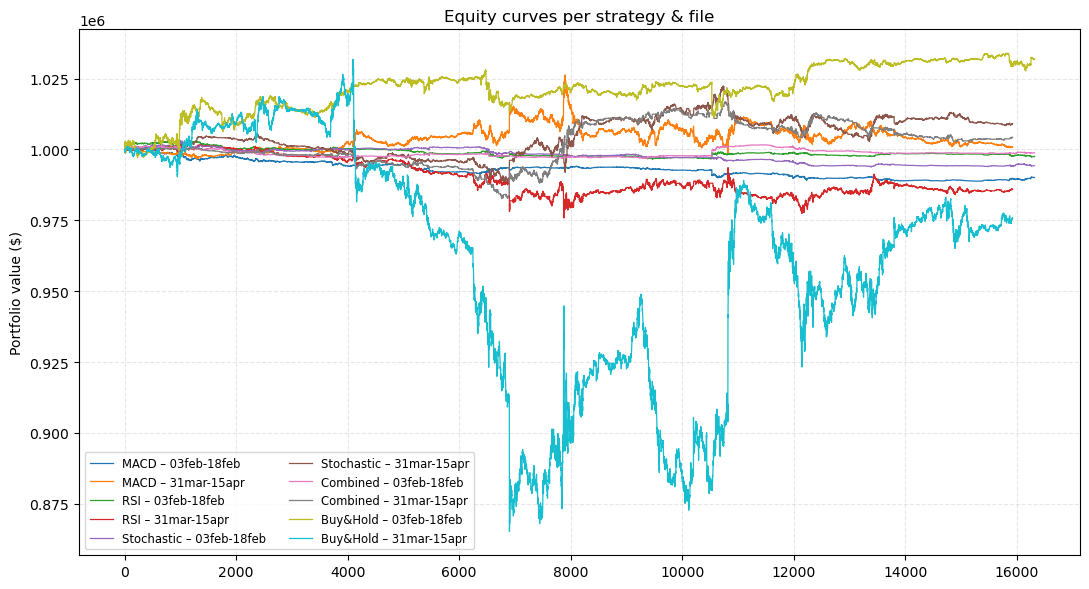

In [3]:
# ── intraday_compare.py ─────────────────────────────────────────────
"""
Analyse **each** 1-minute ES file separately, then compare strategy
performance side-by-side.

Files examined
--------------
• 03feb-18feb.csv   (03 Feb → 18 Feb 2025)
• 31mar-15apr.csv   (31 Mar → 15 Apr 2025)

Strategies
----------
MACD · RSI · Stochastic · Combined (MACD+RSI) · Buy&Hold
"""

from __future__ import annotations
import datetime as dt, re
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# ╭────────────────────╮
# │ 1. Data ingestion  │
# ╰────────────────────╯
_DATE = re.compile(r"(\d{2}[A-Z]{3}\d{4})_")        # e.g. 03FEB2025_

def parse_intraday(path: str | Path) -> pd.DataFrame:
    rows, cur_date = [], None
    path = Path(path)
    with path.open(encoding="utf-8") as fh:
        for raw in fh:
            line = raw.strip()
            if not line:
                continue
            if (m := _DATE.match(line)):                       # date row
                cur_date = dt.datetime.strptime(m[1], "%d%b%Y").date()
                continue
            if line.startswith(("Time Interval", "Summary")) or cur_date is None:
                continue                                       # headers / summaries
            if "-" in line.split(";", 1)[0]:                   # real data row
                cols = line.split(";")[:8]
                h, m = map(int, cols[0].split("-", 1)[0].split(":"))
                ts = dt.datetime.combine(cur_date, dt.time(h, m))
                nums = [float(n.replace(",", ".")) if n else np.nan for n in cols[1:8]]
                rows.append([ts] + nums)

    if not rows:
        raise ValueError(f"Nothing parsed from {path}")
    df = pd.DataFrame(rows, columns=[
        "timestamp", "close", "net", "open", "high", "low", "ticks", "volume"
    ]).set_index("timestamp")
    return df[["open", "high", "low", "close", "volume"]]


# ╭────────────────────╮
# │ 2. Indicators      │
# ╰────────────────────╯
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ATR
    df["H-L"]   = df.high - df.low
    df["H-PC"]  = (df.high - df.close.shift()).abs()
    df["L-PC"]  = (df.low  - df.close.shift()).abs()
    df["TR"]    = df[["H-L", "H-PC", "L-PC"]].max(axis=1)
    df["ATR"]   = df.TR.rolling(14).mean()

    # MACD
    s, l, sig = 3, 15, 5
    df["MACD"]        = df.close.ewm(span=s, adjust=False).mean() - df.close.ewm(span=l, adjust=False).mean()
    df["MACD_signal"] = df.MACD.ewm(span=sig, adjust=False).mean()
    df["Signal_MACD"] = np.where(df.MACD > df.MACD_signal, 1, -1)

    # RSI
    delta, n = df.close.diff(), 14
    gain, loss = delta.clip(lower=0), -delta.clip(upper=0)
    rs = gain.rolling(n).mean() / loss.rolling(n).mean()
    df["RSI"]        = 100 - 100 / (1 + rs)
    df["Signal_RSI"] = np.select([df.RSI < 30, df.RSI > 70], [1, -1], 0)

    # Stochastic
    look = 14
    ll, hh = df.low.rolling(look).min(), df.high.rolling(look).max()
    df["%K"] = (df.close - ll) / (hh - ll) * 100
    df["%D"] = df["%K"].rolling(3).mean()
    prev_k, prev_d = df["%K"].shift(), df["%D"].shift()
    buy  = (prev_k < prev_d) & (df["%K"] > df["%D"]) & (df["%K"] < 20)
    sell = (prev_k > prev_d) & (df["%K"] < df["%D"]) & (df["%K"] > 80)
    df["Signal_Stoch"] = 0
    df.loc[buy,  "Signal_Stoch"] = 1
    df.loc[sell, "Signal_Stoch"] = -1

    # Combined MACD+RSI
    df["Signal_Comb"] = 0
    df.loc[(df.Signal_MACD == 1) & (df.Signal_RSI == 1), "Signal_Comb"]  = 1
    df.loc[(df.Signal_MACD == -1) & (df.Signal_RSI == -1), "Signal_Comb"] = -1
    return df


# ╭────────────────────╮
# │ 3. Back-test       │
# ╰────────────────────╯
def _qty(price: float, cash: float, pct: float = .2, cap: int = 500) -> int:
    return min(cap, int((cash * pct) / price))

def _backtest(df: pd.DataFrame, sig: str, cash0: float = 1_000_000):
    cash, pos = cash0, 0
    fee, slm, tpm = 1., 1.5, 3.0
    entry = sl = tp = None
    port, logs = [], []

    for price, s, atr in zip(df.close, df[sig], df.ATR):
        # exit
        if pos > 0 and (price >= tp or price <= sl):
            pnl = (price - entry) * pos - fee
            cash += pos * price - fee; pos = 0
            logs.append(f"EXIT LONG pnl {pnl:.2f}")
        elif pos < 0 and (price <= tp or price >= sl):
            pnl = (entry - price) * -pos - fee
            cash -= price * -pos + fee; pos = 0
            logs.append(f"EXIT SHORT pnl {pnl:.2f}")

        # entry
        if pos == 0 and s and not np.isnan(atr):
            qty = _qty(price, cash)
            if qty:
                if s == 1:
                    cash -= qty * price + fee; pos = qty
                    entry, sl, tp = price, price - slm * atr, price + tpm * atr
                    logs.append(f"BUY  {qty}@{price:.2f}")
                else:
                    cash += qty * price - fee; pos = -qty
                    entry, sl, tp = price, price + slm * atr, price - tpm * atr
                    logs.append(f"SHORT {qty}@{price:.2f}")
        port.append(cash if pos == 0 else cash + pos * price)
    return port, logs

def _hold(df: pd.DataFrame, cash0: float = 1_000_000):
    p0 = df.close.iloc[0]
    qty = int(cash0 / p0); cash = cash0 - qty * p0
    port = cash + qty * df.close
    return port.tolist(), [f"BUY&HOLD {qty}@{p0:.2f}"]

def _mdd(arr):  # max draw-down
    arr = np.array(arr); roll = np.maximum.accumulate(arr)
    return float(((arr - roll) / roll).min())

def _sharpe(arr):
    r = pd.Series(arr).pct_change().dropna()
    return float(r.mean() / r.std()) if r.std() else np.nan


# ╭────────────────────╮
# │ 4. Comparison loop │
# ╰────────────────────╯
_DATA = {
    "03feb-18feb": Path("/Users/carl/Desktop/Speciale/Kode/Data/03feb-18feb.csv"),
    "31mar-15apr": Path("/Users/carl/Desktop/Speciale/Kode/Data/31mar-15apr.csv"),
}

_STRATS: Dict[str, str | None] = {
    "MACD":      "Signal_MACD",
    "RSI":       "Signal_RSI",
    "Stochastic":"Signal_Stoch",
    "Combined":  "Signal_Comb",
    "Buy&Hold":  None,
}

def run_comparison() -> pd.DataFrame:
    out_rows, plots = [], {}
    for name, path in _DATA.items():
        raw   = parse_intraday(path)
        df    = add_indicators(raw)

        for strat, sig in _STRATS.items():
            if strat == "Buy&Hold":
                port, log = _hold(df)
            else:
                port, log = _backtest(df, sig)
            out_rows.append(dict(
                File=name, Strategy=strat,
                Final=port[-1], Profit=port[-1]-1_000_000,
                Sharpe=_sharpe(port), MaxDD=_mdd(port),
                Trades=len([l for l in log if l.startswith(("BUY", "SHORT"))]),
            ))
            plots.setdefault(strat, {}).update({name: port})

    # ── pretty table
    df_res = pd.DataFrame(out_rows).set_index(["File","Strategy"])
    df_res = df_res.sort_index(level=0)
    print("\n===== PERFORMANCE COMPARISON =====")
    print(df_res.round(2).to_string())
    print()

    # ── overlay equity curves
    fig, ax = plt.subplots(figsize=(11,6))
    for strat, d in plots.items():
        for file, port in d.items():
            lbl = f"{strat} – {file}"
            ax.plot(port, label=lbl, linewidth=.9)
    ax.set_title("Equity curves per strategy & file")
    ax.set_ylabel("Portfolio value ($)")
    ax.legend(ncol=2, fontsize="small")
    ax.grid(alpha=.3, linestyle="--")
    plt.tight_layout()
    plt.show()

    return df_res

# expose global results when imported
RESULTS_DF = run_comparison() if __name__ == "__main__" else None
